## Harmony Py Library

### Basic Workflow Example

This notebook shows three basic examples of Harmony jobs, each using a Harmony test Collection. The first example requests a spatial subset of Alaska, the second a temporal subset (a single-month timespan), and the third shows a combination of both spatial and temporal subsetting.

First, we import a helper module for the notebook, but then import the Harmony Py classes we need to make a request.

In [1]:
import helper

In [2]:
import datetime as dt
from harmony import BBox, Client, Collection, Request

First let's prompt for your CMR credentials (UAT).

In [3]:
username = helper.Text(placeholder='captainmarvel', description='Username')
helper.display(username)
password = helper.Password(placeholder='Password', description='Password')
helper.display(password)

Text(value='', description='Username', placeholder='captainmarvel')

Password(description='Password', placeholder='Password')

Now we create a Harmony Client object, passing in the `auth` tuple containing the username and password entered above.

In [4]:
harmony_client = Client(auth=(username.value, password.value))

Next, we create a Collection object with the CMR collection id for our test collection. We then create a Request which specifies the collection, and a `spatial` `BBox` describing the bounding box for the area we're interested in. We'll see later in the notebook how to make sure the request we have is valid.

In [5]:
collection = Collection(id='C1234088182-EEDTEST')

request = Request(
    collection=collection,
    spatial=BBox(-165, 52, -140, 77)
)

Now that we have a request, we can submit it to Harmony using the Harmony Client object we created earlier. We'll get back a JSON object that describes the Harmony job that we've submitted. As you can see, the Job contains the original request that was submitted to Harmony, its status, as well as a URL where we can get the Job's current status, and its results if it has completed.

In [6]:
job1 = harmony_client.submit(request)

helper.JSON(job1)

<IPython.core.display.JSON object>

Now using our helper module, we'll wait for the Job to complete, and then we'll download the results and view them.

Waiting for the job to finish
Job is running: 0%
Job is running: 0%
Job is running: 0%
Job is running: 0%
Job is running: 0%
Job is running: 0%
Job is running: 0%
Job is running: 0%
Job is running: 0%
Job is running: 0%
Job is running: 0%
Job is running: 0%
Job is running: 0%
Job is running: 50%
Job is running: 50%
Job is running: 50%
Job is running: 50%
Job is running: 50%
Job is running: 50%
Job is running: 75%
Job is running: 75%
Job is running: 75%
Job is running: 75%
Job is running: 75%
Job is running: 75%
Job is running: 75%
Job is running: 75%
Job is running: 99%
Job is running: 99%
Job is successful: 100%
  2020_01_11_7fff00_global_subsetted.nc.tif


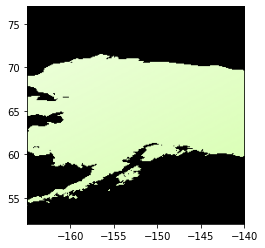

  2020_01_12_cbff00_global_subsetted.nc.tif


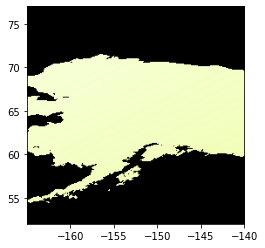

  2020_01_13_ffe500_global_subsetted.nc.tif


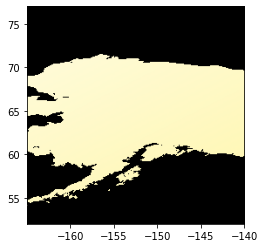

  2020_01_14_ff9900_global_subsetted.nc.tif


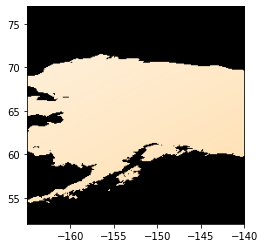

  2020_01_15_ff4c00_global_subsetted.nc.tif


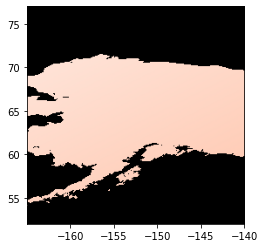

  2020_01_16_ff0000_global_subsetted.nc.tif


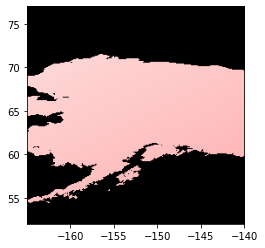

  2020_08_01_7f00ff_north_america_subsetted.nc.tif


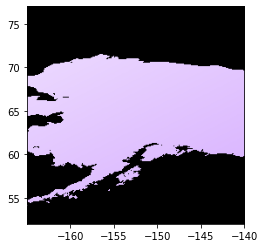

  2020_08_02_3200ff_north_america_subsetted.nc.tif


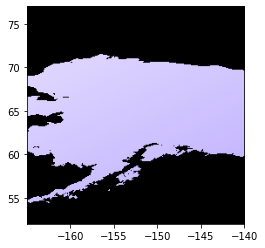

  2020_08_03_0019ff_north_america_subsetted.nc.tif


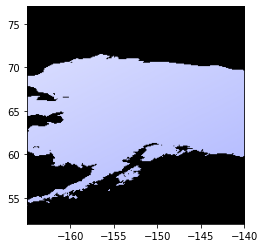

  2020_08_04_0065ff_north_america_subsetted.nc.tif


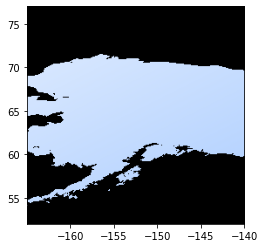

  2020_01_01_7f00ff_global_subsetted.nc.tif


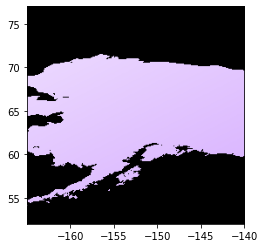

  2020_01_02_3200ff_global_subsetted.nc.tif


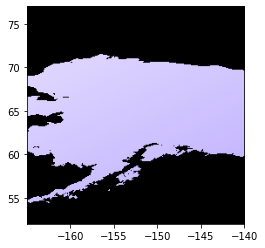

  2020_01_03_0019ff_global_subsetted.nc.tif


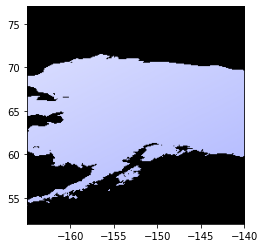

  2020_01_04_0065ff_global_subsetted.nc.tif


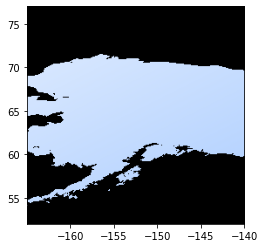

  2020_01_05_00b2ff_global_subsetted.nc.tif


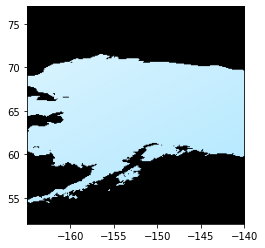

  2020_01_06_00feff_global_subsetted.nc.tif


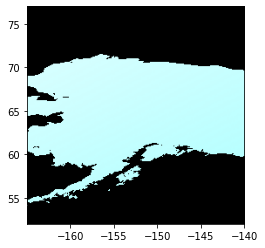

  2020_01_07_00ffb2_global_subsetted.nc.tif


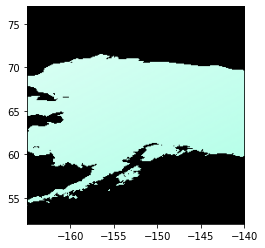

  2020_01_08_00ff66_global_subsetted.nc.tif


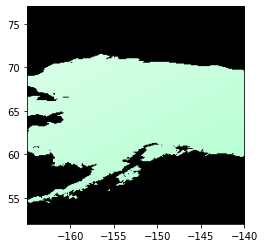

  2020_01_09_00ff19_global_subsetted.nc.tif


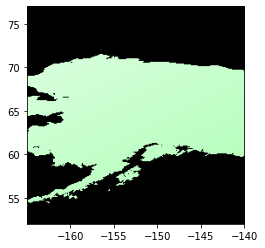

  2020_01_10_32ff00_global_subsetted.nc.tif


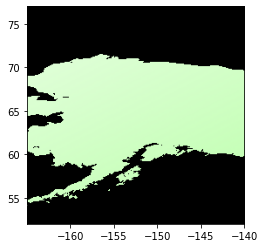

  2020_08_15_ff4c00_north_america_subsetted.nc.tif


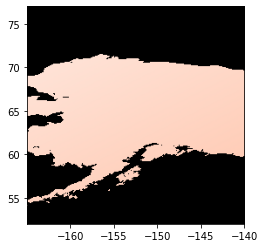

  2020_08_16_ff0000_north_america_subsetted.nc.tif


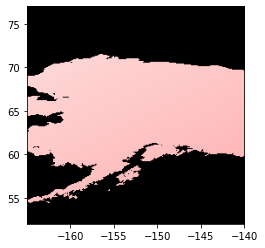

  2020_08_05_00b2ff_north_america_subsetted.nc.tif


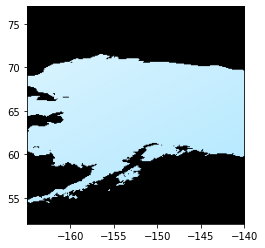

  2020_08_06_00feff_north_america_subsetted.nc.tif


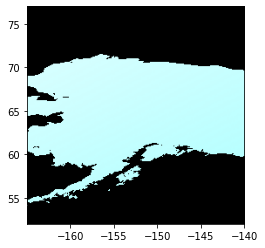

  2020_08_07_00ffb2_north_america_subsetted.nc.tif


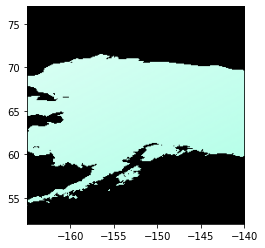

  2020_08_08_00ff66_north_america_subsetted.nc.tif


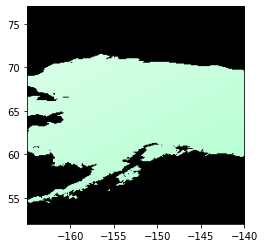

  2020_08_09_00ff19_north_america_subsetted.nc.tif


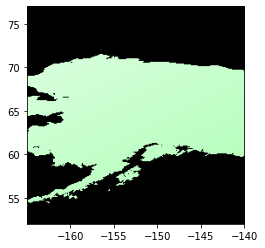

  2020_08_10_32ff00_north_america_subsetted.nc.tif


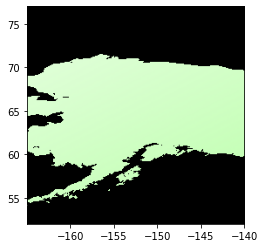

  2020_08_11_7fff00_north_america_subsetted.nc.tif


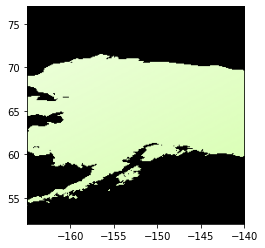

  2020_08_12_cbff00_north_america_subsetted.nc.tif


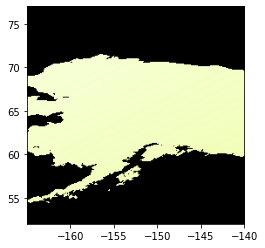

  2020_08_13_ffe500_north_america_subsetted.nc.tif


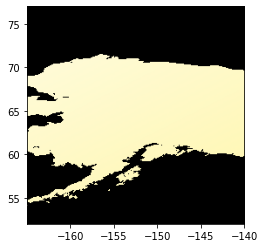

  2020_08_14_ff9900_north_america_subsetted.nc.tif


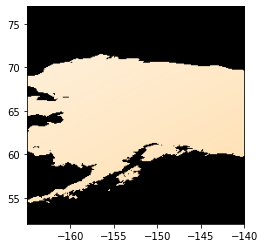

In [7]:
helper.download_and_show_results(harmony_client, job1)

Now we show a Harmony request for a temporal range: one month in 2020. As before, we create a Request, and submit it with the same Harmony Client we used above.

In [ ]:
request = Request(
    collection=collection,
    temporal={
        'start': dt.datetime(2020, 6, 1),
        'stop': dt.datetime(2020, 6, 30)
    })

job2 = harmony_client.submit(request)

helper.JSON(job2)

In [ ]:
download_and_show_results(job2)

Finally, we show a Harmony request for both a spatial and temporal range. We create the Request and simply specify both a `spatial` bounds and a `temporal` range, submitting it with the Harmony Client.

In [ ]:
request = Request(
    collection=collection,
    spatial=BBox(-165, 52, -140, 77),
    temporal={
        'start': dt.datetime(2010, 1, 1),
        'stop': dt.datetime(2020, 12, 30)
    })

job3 = harmony_client.submit(request)

helper.JSON(job3)

In [ ]:
download_and_show_results(job3)

Now that we know how to make a request, let's investigate how the Harmony Py library can help us make sure we have a valid request. Recall that we used the Harmony `BBox` type to provide a spatial constraint in our request. If we investigate its help text, we see that we create a `BBox` by providing the western, southern, eastern, and northern latitude/longitude bounds for a bounding box.

In [8]:
help(BBox)

Help on class BBox in module harmony.harmony:

class BBox(builtins.tuple)
 |  BBox(w: float, s: float, e: float, n: float)
 |  
 |  A bounding box specified by western & eastern longitude,
 |  southern & northern latitude constraints.
 |  
 |  Method resolution order:
 |      BBox
 |      builtins.tuple
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getnewargs__(self)
 |      Return self as a plain tuple.  Used by copy and pickle.
 |  
 |  __repr__(self) -> str
 |      Return repr(self).
 |  
 |  _asdict(self)
 |      Return a new dict which maps field names to their values.
 |  
 |  _replace(self, /, **kwds)
 |      Return a new BBox object replacing specified fields with new values
 |  
 |  ----------------------------------------------------------------------
 |  Class methods defined here:
 |  
 |  _make(iterable) from builtins.type
 |      Make a new BBox object from a sequence or iterable
 |  
 |  ----------------------------------------------------------------

Now let's create an invalid bounding box by specifying a longitude less than -180 and a northern latitude less than its southern bounds:

In [11]:
collection = Collection(id='C1234088182-EEDTEST')

request = Request(
    collection=collection,
    spatial=BBox(-183, 40, 10, 30)
)

print(f"Request valid? {request.is_valid()}")
for m in request.error_messages():
    print(" * " + m)

Request valid? False
 * Southern latitude must be less than Northern latitude
 * Western longitude must be greater than -180.0


Similarly, we can see errors in the temporal parameter:

In [12]:
collection = Collection(id='C1234088182-EEDTEST')

request = Request(
    collection=collection,
    temporal={
        'start': dt.datetime(2020, 12, 30),
        'stop': dt.datetime(2010, 1, 1)
    }
)

print(f"Request valid? {request.is_valid()}")
for m in request.error_messages():
    print(" * " + m)

Request valid? False
 * The temporal range's start must be earlier than its stop datetime.


So before submitting a Harmony Request, you can test your request to see if it's valid and how to fix it if not:

In [ ]:
collection = Collection(id='C1234088182-EEDTEST')

request = Request(
    collection=collection,
    spatial=BBox(-183, 40, 10, 30),
    temporal={
        'start': dt.datetime(2020, 12, 30),
        'stop': dt.datetime(2010, 1, 1)
    }
)

print(f"Request valid? {request.is_valid()}")
for m in request.error_messages():
    print(" * " + m)